Network Built: 154 Nodes, 4046 Edges

Top 10 Most Central Actors (Hubs):
                                                Actor       Category  \
9                    Canada Foundation for Innovation     Government   
21                              Global Affairs Canada     Government   
4                 Business Development Bank of Canada     Government   
83  Innovation, Science and Economic Development C...     Government   
68                                             D-Wave       Industry   
67                           Creative Destruction Lab  Civil Society   
70                                               DRDC     Government   
71            Defence Research and Development Canada     Government   
72                     Department of National Defence     Government   
69                                                DND     Government   

    Degree_Centrality  Betweenness_Centrality  
9            0.764706                0.235681  
21           0.764706                0

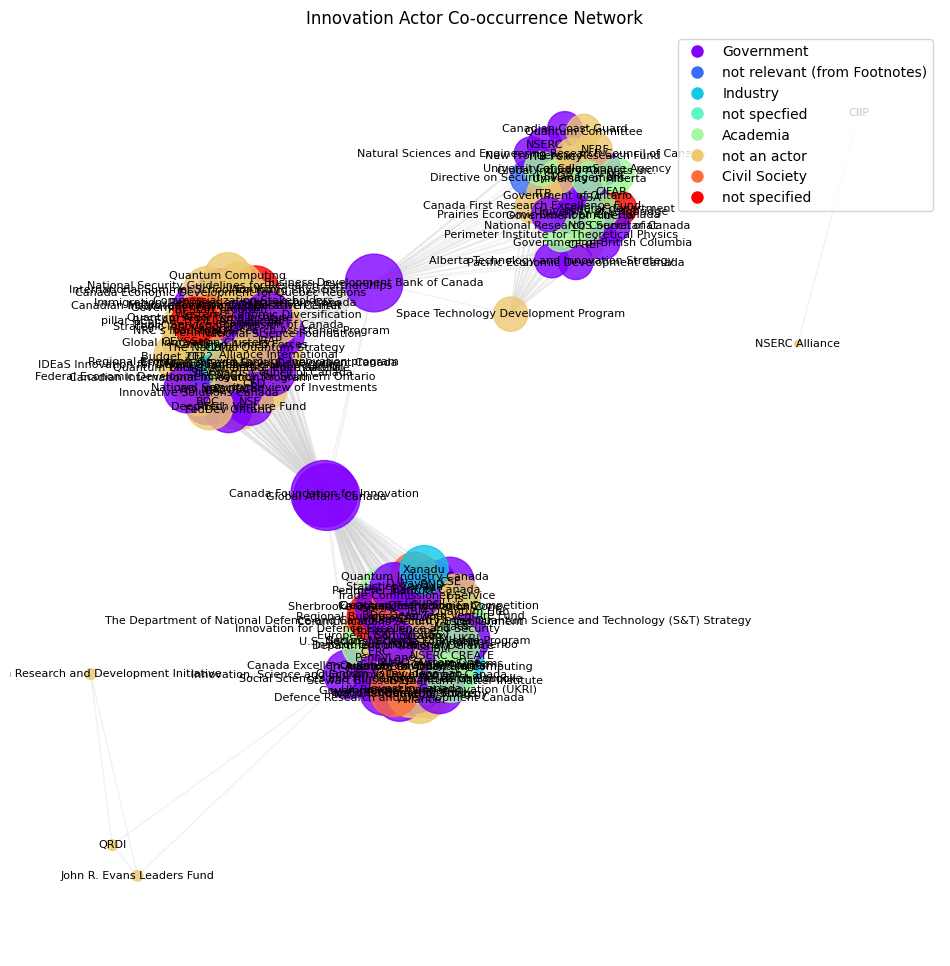

In [4]:
# Cell 7: Network Visualization and Analysis
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import pandas as pd

# Load data
df = pd.read_csv("entities_ready_for_network.csv")

# Initialize Graph
G = nx.Graph()

# --- A. Build Edges (Co-occurrence in Block) ---
# Group by Document and Block (Paragraph level co-occurrence)
grouped = df.groupby(['Doc_ID', 'Block_ID'])['Label'].apply(list)

edge_list = []
for actors in grouped:
    # We need at least 2 actors to form a link
    if len(actors) > 1:
        # Sort to ensure (A,B) is same as (B,A)
        for u, v in combinations(sorted(actors), 2):
            edge_list.append((u, v))

# Add edges with weights (frequency of co-occurrence)
for u, v in edge_list:
    if G.has_edge(u, v):
        G[u][v]['weight'] += 1
    else:
        G.add_edge(u, v, weight=1)

# Add Node Attributes (Category)
# Create a mapping of Label -> Category
cat_map = df.set_index('Label')['qh_category'].to_dict()
nx.set_node_attributes(G, cat_map, name="category")

print(f"Network Built: {G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges")

# --- B. Calculate Centrality (Emphasis) ---
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Create a DataFrame for Analysis
ranking = pd.DataFrame({
    'Actor': list(G.nodes()),
    'Category': [G.nodes[n]['category'] for n in G.nodes()],
    'Degree_Centrality': [degree_cent[n] for n in G.nodes()],
    'Betweenness_Centrality': [betweenness_cent[n] for n in G.nodes()]
}).sort_values(by='Degree_Centrality', ascending=False)

print("\nTop 10 Most Central Actors (Hubs):")
print(ranking.head(10))
ranking.to_csv("rq2_network_stats.csv", index=False)

# --- C. Visualization (Static) ---
plt.figure(figsize=(12, 12))

# Layout algorithm (Spring usually works best for social networks)
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

# Color mapping for categories
categories = list(set(cat_map.values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
color_map = {cat: col for cat, col in zip(categories, colors)}
node_colors = [color_map.get(G.nodes[n]['category'], 'grey') for n in G.nodes()]

# Draw
nx.draw_networkx_nodes(G, pos, node_size=[v * 3000 for v in degree_cent.values()], node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='lightgrey')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cat,
                          markerfacecolor=col, markersize=10) for cat, col in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.title("Innovation Actor Co-occurrence Network")
plt.axis('off')
plt.show()

Loading data...
Building entity lookup map...
Scanning 528 paragraphs. This may take a moment...


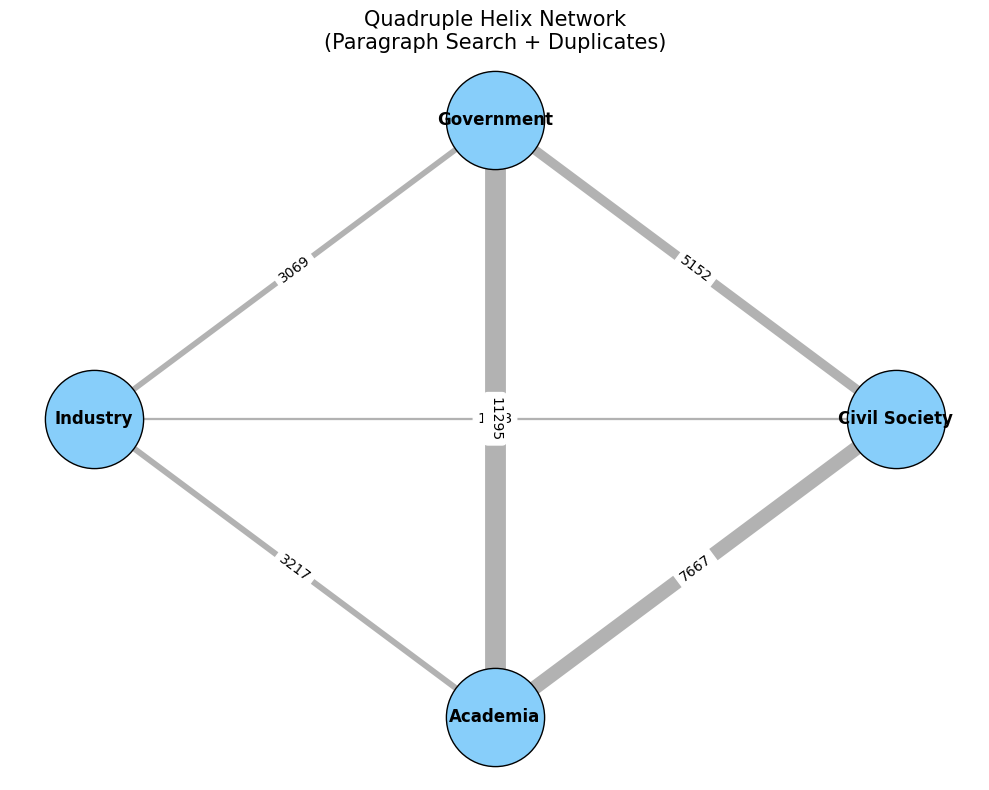

✅ Graph generated with duplicate weighting!


In [5]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import re

# --- 1. CONFIGURATION ---
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]

# Files (Ensure these match your actual filenames)
text_csv = "output.csv"       # The file with 'Paragraph_ID' and 'text'
entities_csv = "2entities_to_edit.csv"    # The file with 'qh_category' (manual or auto)

# --- 2. LOAD & PREPARE DATA ---
print("Loading data...")
df_text = pd.read_csv(text_csv).fillna("")
df_ent = pd.read_csv(entities_csv).fillna("")

# Filter for the 4 Helix Categories
df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()
df_ent = df_ent[df_ent['qh_category'].isin(TARGETS)]

# Optimize: Create a dictionary mapping Doc_ID -> List of (Entity Name, Category)
# This restricts our search scope to only entities that actually belong to the document.
print("Building entity lookup map...")
doc_entity_map = {}

for doc_id, group in df_ent.groupby('Doc_ID'):
    # Store unique entities for this doc
    # We sort by length (descending) so if we wanted to prevent partial matches we could,
    # but here we just store them.
    entities = list(zip(group['entity_name'].astype(str), group['qh_category']))
    doc_entity_map[doc_id] = entities

# --- 3. BUILD NETWORK ---
G = nx.Graph()
G.add_nodes_from(TARGETS)

print(f"Scanning {len(df_text)} paragraphs. This may take a moment...")

for _, row in df_text.iterrows():
    doc_id = row['Doc_ID']
    text = str(row['text'])
    
    # Skip empty text
    if not text.strip(): continue

    # Retrieve potential entities for this document
    potential_entities = doc_entity_map.get(doc_id, [])
    
    if not potential_entities:
        continue

    # Find ALL occurrences of entities in this paragraph (including duplicates)
    found_categories = []
    
    for name, category in potential_entities:
        # Regex search: Case-insensitive
        # re.escape handles special characters in names (like "D-Wave")
        matches = re.findall(re.escape(name), text, re.IGNORECASE)
        
        # If "Government" appears 3 times, we add 'Government' 3 times to the list
        if matches:
            found_categories.extend([category] * len(matches))

    # If fewer than 2 entities found, no interaction possible
    if len(found_categories) < 2:
        continue

    # Generate Interactions (Clique)
    # We create links between EVERY combination found.
    # If found_categories = [Gov, Gov, Ind], we get pairs: (Gov, Gov), (Gov, Ind), (Gov, Ind)
    # We filter out self-loops (c1 != c2) unless you specifically want them.
    for c1, c2 in itertools.combinations(sorted(found_categories), 2):
        if c1 != c2:  # Only count cross-category interactions
            if G.has_edge(c1, c2):
                G[c1][c2]['weight'] += 1
            else:
                G.add_edge(c1, c2, weight=1)

# --- 4. VISUALIZE ---
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)

edges = G.edges(data=True)
weights = [data['weight'] for u, v, data in edges]
max_weight = max(weights) if weights else 1

# Draw
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='#87CEFA', edgecolors='black')
nx.draw_networkx_edges(G, pos, width=[(w / max_weight) * 15 for w in weights], alpha=0.6, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Edge Labels
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Quadruple Helix Network\n(Paragraph Search + Duplicates)", fontsize=15)
plt.axis('off')
plt.tight_layout()

plt.savefig("qh_network_search_duplicates.png")
plt.show()

print("✅ Graph generated with duplicate weighting!")

Loading data...
Building entity lookup map...
Scanning 528 paragraphs. This may take a moment...

Generating Interaction Matrix...
Matrix saved to qh_interaction_matrix_with_selfloops.csv
               Civil Society  Government  Industry  Academia
Civil Society             18         182        12        60
Government               182        1490       175       454
Industry                  12         175        17        42
Academia                  60         454        42        63


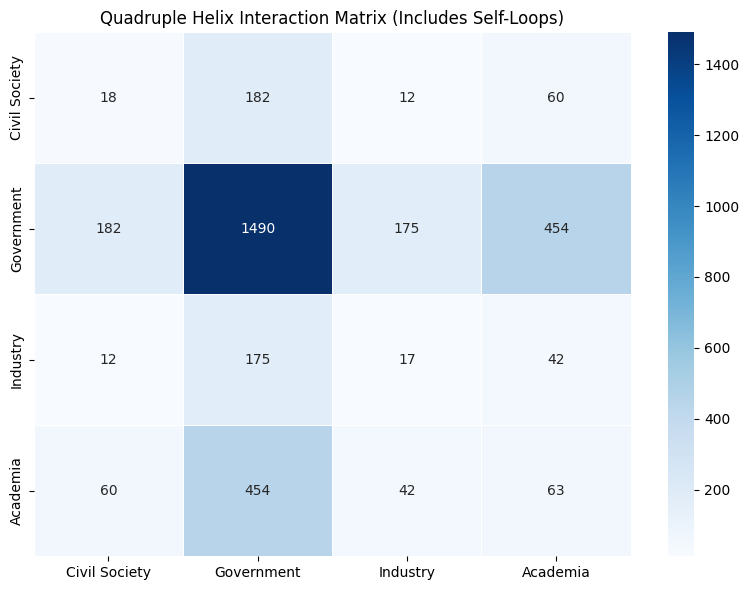

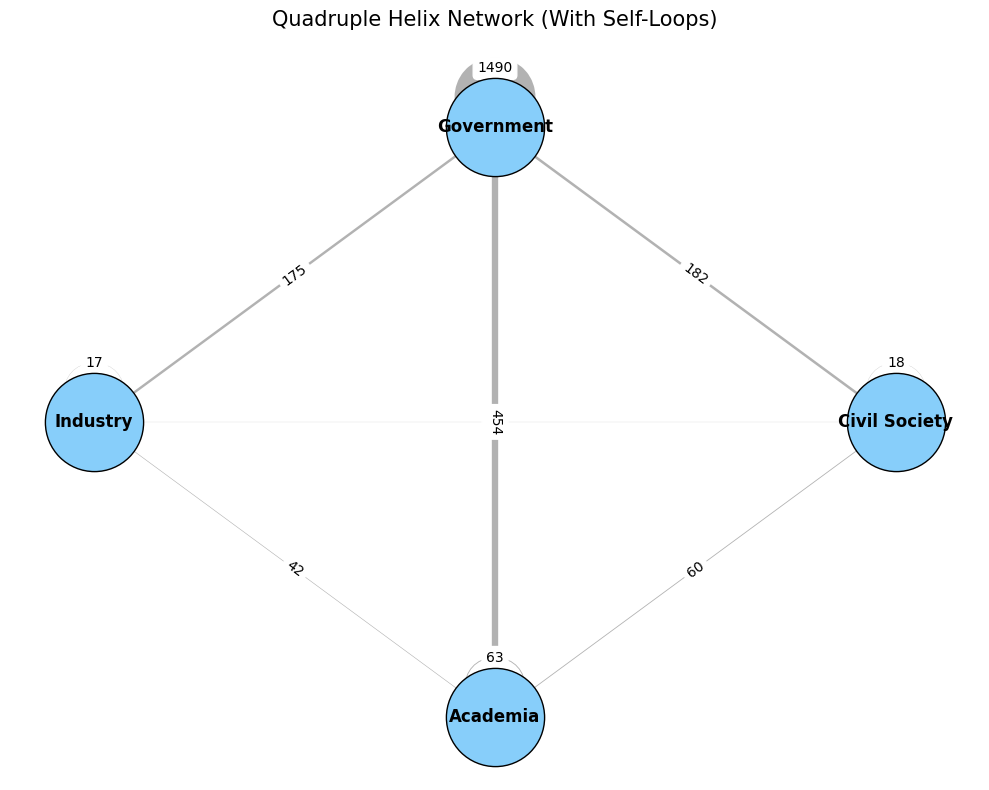

✅ Analysis Complete!


In [6]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# --- 1. CONFIGURATION ---
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]

# Using the files generated in previous steps
text_csv = "paragraphs_master.csv"       
entities_csv = "2entities_filled.csv"    

# --- 2. LOAD & PREPARE DATA ---
print("Loading data...")
df_text = pd.read_csv(text_csv).fillna("")
df_ent = pd.read_csv(entities_csv).fillna("")

# Filter for the 4 Helix Categories
df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()
df_ent = df_ent[df_ent['qh_category'].isin(TARGETS)]

# Build Entity Lookup Map (Doc_ID -> List of (Name, Category))
print("Building entity lookup map...")
doc_entity_map = {}
for doc_id, group in df_ent.groupby('Doc_ID'):
    entities = list(zip(group['entity_name'].astype(str), group['qh_category']))
    doc_entity_map[doc_id] = entities

# --- 3. BUILD NETWORK ---
G = nx.Graph()
G.add_nodes_from(TARGETS)

print(f"Scanning {len(df_text)} paragraphs. This may take a moment...")

for _, row in df_text.iterrows():
    doc_id = row['Doc_ID']
    text = str(row['text'])
    
    if not text.strip(): continue

    potential_entities = doc_entity_map.get(doc_id, [])
    if not potential_entities: continue

    # Find ALL occurrences of entities (including duplicates)
    found_categories = []
    
    for name, category in potential_entities:
        # Regex search: Case-insensitive
        matches = re.findall(re.escape(name), text, re.IGNORECASE)
        if matches:
            found_categories.extend([category] * len(matches))

    # Need at least 2 entities (even of the same type) to create an interaction
    if len(found_categories) < 2:
        continue

    # Generate Interactions (Clique)
    # We create links between EVERY combination found.
    # If found_categories = [Gov, Gov, Ind]:
    #   1. (Gov, Gov) -> Self-loop (Added!)
    #   2. (Gov, Ind) -> Interaction
    #   3. (Gov, Ind) -> Interaction
    for c1, c2 in itertools.combinations(sorted(found_categories), 2):
        # REMOVED: if c1 != c2: check. Self-loops are now allowed.
        if G.has_edge(c1, c2):
            G[c1][c2]['weight'] += 1
        else:
            G.add_edge(c1, c2, weight=1)

# --- 4. GENERATE MATRICES ---
print("\nGenerating Interaction Matrix...")

# Adjacency Matrix
matrix_df = nx.to_pandas_adjacency(G, nodelist=TARGETS, weight='weight', dtype=int)

# Save Matrix
output_matrix = "qh_interaction_matrix_with_selfloops.csv"
matrix_df.to_csv(output_matrix)

print(f"Matrix saved to {output_matrix}")
print(matrix_df)

# --- 5. VISUALIZATION ---

# Plot 1: Heatmap (Best way to see self-loops on the diagonal)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_df, annot=True, fmt='d', cmap="Blues", linewidths=.5)
plt.title("Quadruple Helix Interaction Matrix (Includes Self-Loops)")
plt.tight_layout()
plt.savefig("qh_matrix_heatmap_selfloops.png")
plt.show()

# Plot 2: Network Graph
# Note: Self-loops in networkx circular_layout are often drawn as small loops on the node.
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)
edges = G.edges(data=True)
weights = [data['weight'] for u, v, data in edges]
max_weight = max(weights) if weights else 1

# Draw Nodes
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='#87CEFA', edgecolors='black')

# Draw Edges
nx.draw_networkx_edges(G, pos, width=[(w / max_weight) * 15 for w in weights], alpha=0.6, edge_color='gray')

# Draw Labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Quadruple Helix Network (With Self-Loops)", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.savefig("qh_network_graph_selfloops.png")
plt.show()

print("✅ Analysis Complete!")

In [7]:
import pandas as pd
import re

# Files
text_csv = "output.csv"
entities_csv = "2entities_to_edit.csv"  # or "entities_to_edit.csv"

# Load Data
df_text = pd.read_csv(text_csv).fillna("")
df_ent = pd.read_csv(entities_csv).fillna("")

# Normalize Categories
df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()

# Build Lookup Map (Doc_ID -> List of Entities)
doc_entity_map = {}
for doc_id, group in df_ent.groupby('Doc_ID'):
    entities = list(zip(group['entity_name'].astype(str), group['qh_category']))
    doc_entity_map[doc_id] = entities

print("Searching for 'Civil Society' x 'Government' interactions...")
print("-" * 60)

count = 0
for _, row in df_text.iterrows():
    doc_id = row['Doc_ID']
    text = str(row['text'])
    
    # Get entities for this doc
    potential_entities = doc_entity_map.get(doc_id, [])
    
    # Find Categories present in this paragraph
    found_cats = set()
    found_entities = []
    
    for name, cat in potential_entities:
        if re.search(re.escape(name), text, re.IGNORECASE):
            found_cats.add(cat)
            found_entities.append(f"{name} ({cat})")
            
    # Check for Interaction
    if "Civil Society" in found_cats and "Government" in found_cats:
        count += 1
        print(f"\n[Match #{count}]")
        print(f"Document: {row['Document_Name']} (Doc {doc_id})")
        print(f"Paragraph ID: {row['Paragraph_ID']}")
        print(f"Entities Found: {', '.join(found_entities)}")
        print(f"Text Snippet: {text[:200]}...") # First 200 chars
        print("-" * 60)

if count == 0:
    print("No interactions found.")

Searching for 'Civil Society' x 'Government' interactions...
------------------------------------------------------------

[Match #1]
Document: Canada's National Quantum Strategy (Doc 1)
Paragraph ID: 67
Entities Found: NQS (not an actor), Government of Canada (Government), CFI (Government), ISC (not an actor), QEYSSat (not an actor), IQC (Academia), University of Waterloo (Academia), Perimeter Institute (Academia), Canada First Research Excellence Fund (not an actor), CFREF (not an actor), Canadian Space Agency (Government), Natural Sciences and Engineering Research Council of Canada (Government), NSERC (Government), MiQro Innovation Collaborative Center (Civil Society), C2MI (Civil Society), Quantum Algorithms Institute (Civil Society), NSERC Alliance (not an actor), Institute for Quantum Computing (Academia), Perimeter (Academia), The Government of Canada (Government), CED (Government), REGI (not an actor), Council (not specified), Invest (Government)
Text Snippet: Research: Develop

In [8]:
# Install pyvis if you haven't (run this in your terminal/notebook)
%pip install pyvis

import pandas as pd
import itertools
import networkx as nx
import re
import numpy as np
from pyvis.network import Network

# --- 1. CONFIGURATION ---
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]
# Hex colors for PyVis
HELIX_COLORS = {
    "Civil Society": "#4ECDC4", 
    "Government": "#45B7D1", 
    "Industry": "#FF6B6B", 
    "Academia": "#96CEB4"
}

text_csv = "paragraphs_master.csv"       
entities_csv = "2entities_filled.csv"    

# --- 2. LOAD & PREPARE DATA ---
print("Loading data...")
df_text = pd.read_csv(text_csv).fillna("")
df_ent = pd.read_csv(entities_csv).fillna("")

df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()
df_ent = df_ent[df_ent['qh_category'].isin(TARGETS)]

doc_entity_map = {}
for doc_id, group in df_ent.groupby('Doc_ID'):
    entities = list(zip(group['entity_name'].astype(str), group['qh_category']))
    doc_entity_map[doc_id] = entities

# --- 3. BUILD NETWORK ---
G = nx.Graph()
G.add_nodes_from(TARGETS)

print("Scanning paragraphs...")
for _, row in df_text.iterrows():
    doc_id = row['Doc_ID']
    text = str(row['text'])
    if not text.strip(): continue

    potential_entities = doc_entity_map.get(doc_id, [])
    if not potential_entities: continue

    found_categories = []
    for name, category in potential_entities:
        matches = re.findall(re.escape(name), text, re.IGNORECASE)
        if matches:
            found_categories.extend([category] * len(matches))

    if len(found_categories) < 2: continue

    for c1, c2 in itertools.combinations(sorted(found_categories), 2):
        if G.has_edge(c1, c2):
            G[c1][c2]['weight'] += 1
        else:
            G.add_edge(c1, c2, weight=1)

# --- 4. PYVIS VISUALIZATION ---
print("Generating Interactive Graph...")

# Create PyVis Network
nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=False)

# Add Nodes with Custom Styling
# Calculate total weight for sizing
degrees = dict(G.degree(weight='weight'))
max_degree = max(degrees.values()) if degrees else 1

for node in TARGETS:
    # Size node by total interactions (degree)
    size = 20 + (degrees.get(node, 0) / max_degree * 50)
    
    nt.add_node(
        node, 
        label=node, 
        color=HELIX_COLORS[node],
        size=size,
        title=f"Total Interactions: {degrees.get(node, 0)}", # Tooltip
        font={'size': 20, 'face': 'arial'}
    )

# Add Edges
for u, v, data in G.edges(data=True):
    weight = data['weight']
    # Scale width
    width = (weight / max_degree) * 10
    if width < 1: width = 1
    
    nt.add_edge(
        u, v, 
        value=weight, 
        width=width,
        title=f"{u} - {v}: {weight} interactions", # Tooltip
        color='#ffffff' # White edges for dark background
    )

# Physics Options for a nice layout
nt.force_atlas_2based()
nt.show_buttons(filter_=['physics']) # Allow user to play with physics settings

output_html = "qh_interactive_network.html"
nt.write_html(output_html)

print(f"✅ Interactive graph saved to: {output_html}")
# You would open this HTML file in Chrome/Firefox

Note: you may need to restart the kernel to use updated packages.
Loading data...
Scanning paragraphs...
Generating Interactive Graph...
✅ Interactive graph saved to: qh_interactive_network.html
